In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

import string


In [42]:
df=pd.read_csv('/content/drive/MyDrive/60.csv')

# Small dataset

In [43]:
df.head()

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,469395,70,Half-Life,84948211,english,the platforming makes me want to eat sand\n,1611014751,1611014751,False,0,...,True,False,False,76561198352346016,120,2,591.0,167.0,530.0,1.611017e+09
1,469396,70,Half-Life,84947859,english,"Really fun, great story an crap.",1611014064,1611014064,True,0,...,True,False,False,76561198074088375,184,11,261.0,283.0,237.0,1.611015e+09
2,469397,70,Half-Life,84946698,czech,nice\n,1611012114,1611012114,True,0,...,True,False,False,76561198960746554,3,2,5608.0,52.0,5555.0,1.611015e+09
3,469398,70,Half-Life,84946092,english,good,1611011237,1611011237,True,0,...,True,False,False,76561198945746887,36,16,3297.0,2811.0,3297.0,1.611000e+09
4,469399,70,Half-Life,84935389,english,"hey, sorry i saw your profile and i just thoug...",1611009975,1611009975,True,0,...,True,False,False,76561198911822629,61,26,1015.0,0.0,1015.0,1.587937e+09


In [44]:
# Output all columns name
list(df.columns)

['Unnamed: 0',
 'app_id',
 'app_name',
 'review_id',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'recommended',
 'votes_helpful',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access',
 'author.steamid',
 'author.num_games_owned',
 'author.num_reviews',
 'author.playtime_forever',
 'author.playtime_last_two_weeks',
 'author.playtime_at_review',
 'author.last_played']

In [45]:
# check if each game has approximate 30 reviews
df_sorted=df.groupby('app_name')['review'].count().sort_values(ascending=False)
df_sorted = df_sorted.reset_index(name='count')
df_sorted

,app_name,count
0,20XX,60
1,Pillars of Eternity II: Deadfire,60
2,SENRAN KAGURA ESTIVAL VERSUS,60
3,SCUM,60
4,Rust,60
...,...,...
310,Sid Meier's Civilization V,58
311,Far Cry 5,58
312,Steel Division: Normandy 44,58
313,Little Nightmares,58


# Data Preprocessing

using nltk to elminate any distraction

In [46]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
# New imports 
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

In [48]:
Columns = ['app_name','language','review']
df_target = df.loc[:, Columns]
df_target.head()

,app_name,language,review
0,Half-Life,english,the platforming makes me want to eat sand\n
1,Half-Life,english,"Really fun, great story an crap."
2,Half-Life,czech,nice\n
3,Half-Life,english,good
4,Half-Life,english,"hey, sorry i saw your profile and i just thoug..."


In [49]:
# We no longer need text columns 
df = df.drop(columns=Columns)
df.head()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,469395,70,84948211,1611014751,1611014751,False,0,0,0.000000,0,True,False,False,76561198352346016,120,2,591.0,167.0,530.0,1.611017e+09
1,469396,70,84947859,1611014064,1611014064,True,0,0,0.000000,0,True,False,False,76561198074088375,184,11,261.0,283.0,237.0,1.611015e+09
2,469397,70,84946698,1611012114,1611012114,True,0,0,0.000000,0,True,False,False,76561198960746554,3,2,5608.0,52.0,5555.0,1.611015e+09
3,469398,70,84946092,1611011237,1611011237,True,0,0,0.000000,0,True,False,False,76561198945746887,36,16,3297.0,2811.0,3297.0,1.611000e+09
4,469399,70,84935389,1611009975,1611009975,True,0,0,0.478261,0,True,False,False,76561198911822629,61,26,1015.0,0.0,1015.0,1.587937e+09


In [50]:
scaler = MinMaxScaler()
df[list(df.columns)] = scaler.fit_transform(df[list(df.columns)])

In [51]:
df_target.head(60)

,app_name,language,review
0,Half-Life,english,the platforming makes me want to eat sand\n
1,Half-Life,english,"Really fun, great story an crap."
2,Half-Life,czech,nice\n
3,Half-Life,english,good
4,Half-Life,english,"hey, sorry i saw your profile and i just thoug..."
5,Half-Life,english,yes.
6,Half-Life,english,The game is as good as people said it was. I w...
7,Half-Life,english,"Amazing game. Its a timeless classic, would de..."
8,Half-Life,english,make the scientists angry
9,Half-Life,english,"""Where the fuck do I go"" The Game."



# TF-IDF
Build TF-IDF index in order to make text eligiable for k-means

statistical method for evaluating the importance of words in a document or corpus of documents. It is a way of measuring how relevant a word is to a document or set of documents by comparing the frequency of the word in the document to its frequency in the entire corpus.

# Heavy Review and App Name preprocess
* normalizing
* stemming
* tokenizing

Option to keep english only records, in order to have some coherence between data, but it is just an empirical hypotesis

In [52]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [53]:
# Should we inlcude title in our analysis?
include_title = False

In [54]:
# some heavy preprocess
i = 0 
def process_row(row):
    global i 
    global include_title
    print("Tfidf Progress: "+str("{:.5f}".format(i/(len(df_target)-1) *100)) + "%",end="\r")
    i += 1
    
    language = row['language']
    reuslt = None
    if(include_title):
        result = (str(row['review']) + " " + str(row['app_name'])).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    else:
        result = (str(row['review'])).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    result = result.replace(',', '')          # Removes commas
    result = result.rstrip('\n')              # Removes line breaks
    result = result.casefold()                # Makes all letters lowercase

    result = re.sub('\W_',' ', result)        # removes specials characters and leaves only words
    result = re.sub("\S*\d\S*"," ", result)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    result = re.sub("\S*@\S*\s?"," ", result) # removes emails and mentions (words with @)
    result = re.sub(r'http\S+', '', result)   # removes URLs with http
    result = re.sub(r'www\S+', '', result)    # removes URLs with www
    
    result = re.sub(r"\s+(.)\1+\b", "",result)               # remove spammed chars
    result = ''.join([i for i in result if not i.isdigit()]) # remove numbers
    result = re.sub(r'[^\w\s]','',result)                    # remove punctuation
   

    listOfTokens = word_tokenize(result)
    twoLetterWord = twoLetters(listOfTokens)


    try: 
        # Not all languages are supported 
        # We remove stopwords and stem only with supported languages
        stopwords = nltk.corpus.stopwords.words(language)
        stopwords.append("game")
        
        param_stemmer = SnowballStemmer(language)
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, stopwords)
        
        

    finally:
        # Output the tokens
        listOfTokens = list(filter(lambda item: len(item) < 25,listOfTokens))   # other spam filter
        listOfTokens = removeWords(listOfTokens, ["game","gam","igr","juego","you","jogao"]) # some game translations (en,en,ru,sp,ch,pt)
        
        result   = " ".join(listOfTokens)
        result = unidecode(result)
        result = re.sub(r'[^\x00-\x7F]+','', result)    # remove non ascii

        return result

In [55]:
english_only = False

In [56]:
if english_only:
    len_ = len(df_target)
    df_target = df_target[df_target.language == 'english']
    df_target.head()
    print("Length before filtering " + str(len_) + " Length after filtering "+ str(len(df_target)))

In [57]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
%%time
df_target['tokens'] = df_target.apply(lambda row: process_row(row),axis=1)

CPU times: user 17.8 s, sys: 2.59 s, total: 20.4 s
Wall time: 18.8 s


In [23]:
df_target.head(60)

,app_name,language,review,tokens
0,Half-Life,english,the platforming makes me want to eat sand\n,the platforming makes me want to eat sand
1,Half-Life,english,"Really fun, great story an crap.",really fun great story an crap
2,Half-Life,czech,nice\n,nice
3,Half-Life,english,good,good
4,Half-Life,english,"hey, sorry i saw your profile and i just thoug...",hey sorry i saw your profile and i just though...
5,Half-Life,english,yes.,yes
6,Half-Life,english,The game is as good as people said it was. I w...,the is as good as people said it was i wasnt b...
7,Half-Life,english,"Amazing game. Its a timeless classic, would de...",amazing its a timeless classic would definitel...
8,Half-Life,english,make the scientists angry,make the scientists angry
9,Half-Life,english,"""Where the fuck do I go"" The Game.",where the fuck do i go the


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
%%time
# tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_target['tokens'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

tf_idf.head()

CPU times: user 821 ms, sys: 911 ms, total: 1.73 s
Wall time: 1.72 s


,0liang,____,_navernoe,_udivitel,_z,aa,aaaa,aaaaa,aaaaaaaa,aaaaaaaaaaaany,...,zyje,zysk,zyskiem,zyto,zyvaet,zywy,zyznosci,zza,zzas,zzerac
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# One hot encoder
convert categorical data into a numerical representation that can be used in machine learning models.

In [26]:
%%time
bool_list = ['recommended','steam_purchase','received_for_free','written_during_early_access']
df[bool_list] = df[bool_list].astype(int)

CPU times: user 4.8 ms, sys: 1.95 ms, total: 6.75 ms
Wall time: 6.43 ms


# Combine Data
Merge one hot and tfidf with some cleanup

In [27]:
df = pd.concat([df, tf_idf], axis=1)

In [28]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
    
df = clean_dataset(df)

In [29]:
df.head()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,...,zyje,zysk,zyskiem,zyto,zyvaet,zywy,zyznosci,zza,zzas,zzerac
0,0.021635,0.0,0.993419,0.994654,0.994654,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.021635,0.0,0.993410,0.994645,0.994645,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.021635,0.0,0.993382,0.994620,0.994620,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.021635,0.0,0.993367,0.994608,0.994608,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.021635,0.0,0.993106,0.994592,0.994592,1.0,0.0,0.0,0.553729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#PCA to reduce size¶
###### After tfifd the size needs to be reduced, we use PCA one again

In [30]:
%%time
df_ = df.copy()

pca__ = IncrementalPCA(n_components = 512, batch_size=4096)
reduced = pca__.fit_transform(df)

CPU times: user 1h 11min 5s, sys: 22min 56s, total: 1h 34min 1s
Wall time: 9min 18s


In [31]:
columns__ = ['pca_comp_%i' % i
   for i in range(reduced.shape[1])
]

df = pd.DataFrame(data = reduced
             , columns = columns__)
df.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_502,pca_comp_503,pca_comp_504,pca_comp_505,pca_comp_506,pca_comp_507,pca_comp_508,pca_comp_509,pca_comp_510,pca_comp_511
0,-0.030782,-0.650474,-0.712152,0.002456,-0.379638,-0.354685,-0.293543,0.003549,-0.006884,0.076077,...,-0.020700,-0.003911,0.002439,0.000869,0.005053,0.016119,0.009068,-0.008243,0.026243,-0.007687
1,0.188135,-0.041282,-0.311958,-0.617299,-0.250933,-0.049886,-0.257554,-0.006987,-0.050018,0.015468,...,0.004100,-0.007437,0.013165,0.007438,-0.007861,0.007325,0.006879,-0.011888,-0.001253,0.001293
2,0.354747,0.354126,-0.609346,-0.056448,-0.298899,-0.011735,-0.262861,-0.037084,-0.065713,-0.018848,...,-0.001594,0.000696,0.001117,-0.001384,-0.000119,-0.000223,0.001185,-0.001379,-0.000549,-0.000538
3,0.365078,0.368210,-0.596246,-0.077488,-0.283669,-0.014227,-0.300349,-0.066881,0.923517,-0.171488,...,0.000159,-0.000484,0.001081,-0.000947,-0.000296,-0.000218,0.000983,-0.001976,-0.000419,-0.000434
4,0.271806,0.151494,-0.605278,-0.022860,-0.297590,0.523558,-0.271692,-0.053749,-0.007988,0.200125,...,0.003053,-0.000068,0.008182,0.000775,0.000445,-0.002508,-0.009007,0.002446,-0.002605,-0.000981


In [32]:
def elbow(df): # Elbow method for best k
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)

        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / df.shape[0]
        mapping2[k] = kmeanModel.inertia_

        print("Iter "+str(k)+" of "+str(max(K))+" done...")
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 1 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 2 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 3 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 4 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 5 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 6 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 7 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 8 of 9 done...


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iter 9 of 9 done...


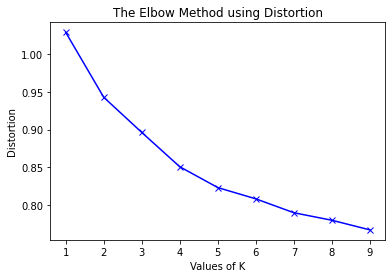

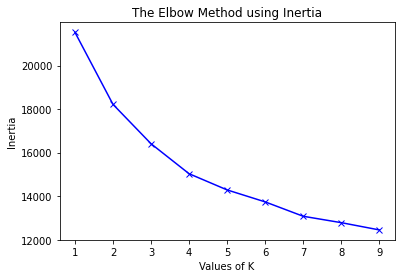

CPU times: user 5min 47s, sys: 2min 24s, total: 8min 11s
Wall time: 46.8 s


In [33]:
%%time
elbow(df)

In [34]:
optimal = 5
kmeans = KMeans(n_clusters=optimal).fit(tf_idf)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#Make sense to clustering¶
#####Plot most common words from clusters

In [35]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

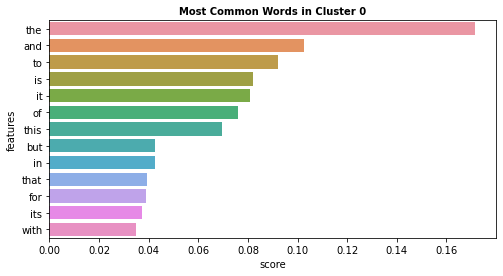

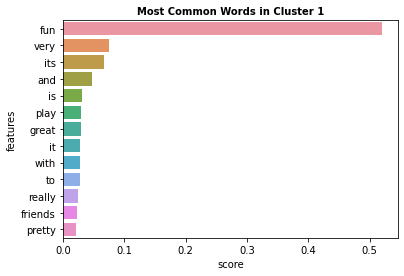

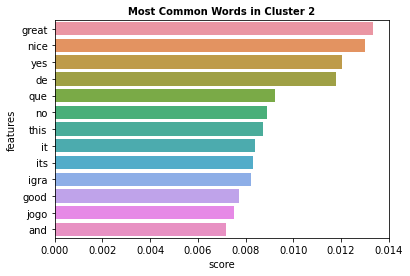

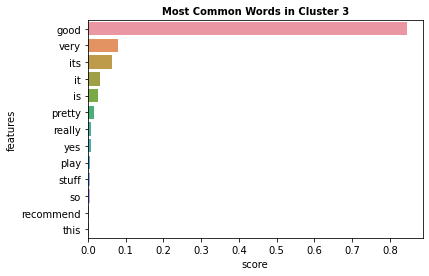

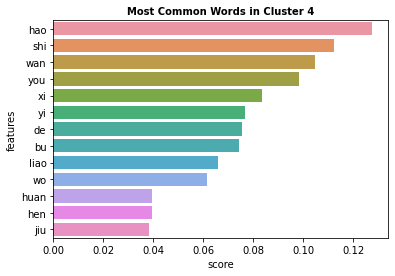

In [36]:
final_df_array = tf_idf.to_numpy()
prediction = kmeans.predict(tf_idf)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

#Word Cloud
#####Try to visualize some info about clusters

In [37]:
from wordcloud   import WordCloud

In [38]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

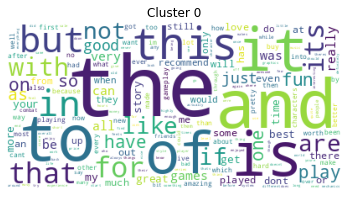

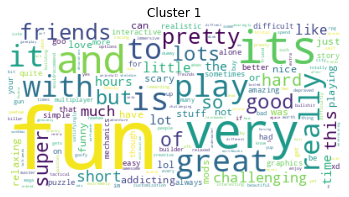

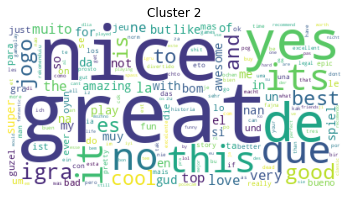

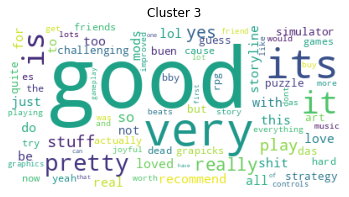

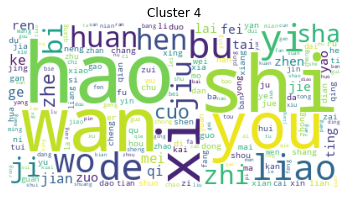

In [39]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = tf_idf.columns
generateWordClouds(centroids)

# Sentiment analysis
Use tokenized data to do sentiment analysis

In [61]:
# Filter data  that have less or equal to 512 tokens
df_target = df_target[df_target['tokens'].notnull()]
#df_target.filter(len(str(df_target.tokens).split())<500)
df_target2 = df_target[df_target["tokens"].apply(lambda x: len(x) <500)]
#df["names"].apply(lambda x: len(x) > 500)
df_target2





,app_name,language,review,tokens
0,Half-Life,english,the platforming makes me want to eat sand\n,the platforming makes me want to eat sand
1,Half-Life,english,"Really fun, great story an crap.",really fun great story an crap
2,Half-Life,czech,nice\n,nice
3,Half-Life,english,good,good
5,Half-Life,english,yes.,yes
...,...,...,...,...
18895,Townscaper,russian,НОРМАЛЬНО\n,normal'no
18896,Townscaper,english,That a feeling It is a game I wanted hole my l...,that a feeling it is a i wanted hole my life f...
18897,Townscaper,russian,"Классно позалипать когда скучно , но я бы сдел...",klassno pozalipat' kogda skuchno no ia by sdel...
18898,Townscaper,russian,"мне понравилась эта игра, милая графика\nсоветую",mne ponravilas' eta igra milaia grafika sovetuiu


In [62]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.6 MB/s eta 0:00:00


In [63]:
import transformers
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")
data = df_target2["tokens"].tolist()
results=sentiment_pipeline(data)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [64]:
df = pd.DataFrame(results)
df.to_csv("sentiment_analysis_results.csv", index=False)